This notebook uses the mols2grid library.  To install do this. 
```
pip install mols2grid
```

## Using sub_search.py in a Jupyter notebook 

In this notebook we'll look at how we can use subsearch.py in a jupyter notebook.  We begin by importing the process search function. 

In [53]:
from sdf_search import build_sdf_database, process_search
import mols2grid 
from rdkit import Chem
import useful_rdkit_utils as uru

In this notebook we'll look at how we can use subsearch.py in a jupyter notebook.  To begin, we will create a database for substructure and similarity.  This database will consist of three files. 
- demo_sub.h5 - fingerprints for substructure searches
- demo_sim.h5 - fingerprints for similarity searches
- demo.ddb - a DuckDB database containing the data fields from the SDF

In [93]:
help(build_sdf_database)

Help on function build_sdf_database in module sdf_search:

build_sdf_database(sdf_name: str, outfile_prefix: str) -> None
    Orchestrates the conversion of an SDF file to CSV, SMILES, FpSim2, and DuckDB databases,
    printing the runtime for each step.
    
    Args:
        sdf_name: Path to the input SDF file.
        outfile_prefix: Prefix for all output files.



In [94]:
build_sdf_database("demo.sdf","demo")

Reading demo.sdf to create demo.csv and demo.smi


  0%|          | 0/5000 [00:00<?, ?it/s]

[21:07:39] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 8 ignored
[21:07:39] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 10 ignored
[21:07:39] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 12 ignored
[21:07:39] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 6 ignored
[21:07:39] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 6 ignored
[21:07:39] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 10 ignored
[21:07:39] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 12 ignored
[21:07:39] The 2 defining bonds for an atropisomer are co-planar - atoms are: 7 2
[21:07:39] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 6 ignored
[21:07:39] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 10 ignored


Done. Runtime: 0.33 seconds
Building FpSim2 substructure database demo_sub.h5 from demo.smi
Done. Runtime: 2.80 seconds
Building FpSim2 similarity database demo_sim.h5 from demo.smi
Done. Runtime: 2.41 seconds
Building DuckDB database demo.ddb from demo.csv
Done. Runtime: 0.02 seconds
Removing temporary files demo.smi and demo.csv


We can perform searches using the `process_search` function. Note that if the `outfile_name` option is `None`, the function returns a Pandas DataFrame. 

### Similarity Search

We can define a query as SMILES. 

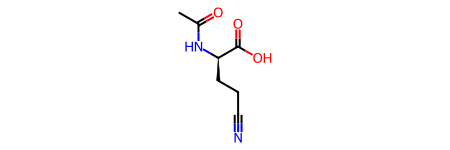

In [96]:
sim_query = "CC(=O)N[C@H](CCC#N)C(=O)O"
Chem.MolFromSmiles(sim_query)

If we set the `search_type` argment to `"sim"` we perform a similarity search. 

In [97]:
search_res = process_search("sim","demo",sim_query,threshold=0.5)

Runtime for similarity search: 0.03 seconds


As mentioned above, the search results are returned as a dataframe. 

In [98]:
search_res

,SMILES,Index,Name,MolWt,LogP,HBD,HBA,TPSA,mol_id,Tanimoto
0,CC(=O)N[C@H](CCC#N)C(=O)O,4,59544196.0,170.168,-0.12052,2.0,3.0,90.19,4,1.000000
3,CC(=O)N[C@H](CO)C(=O)O,4396,158174.0,147.130,-1.43200,3.0,3.0,86.63,4396,0.551724
1,C#CC[C@@H](NC(C)=O)C(=O)O,2846,402662.0,155.153,-0.40100,2.0,2.0,66.40,2846,0.531250
2,CC(=O)N[C@H](CC(N)=O)C(=O)O,4080,135376.0,174.156,-1.54890,3.0,3.0,109.49,4080,0.500000


We can use mols2grid to display the search results. Note how we use the `transform` argument to set the number of decimal places for the `Tanimoto` field. 

In [108]:
mols2grid.display(search_res,subset=["img","Name","Tanimoto"],transform={"Tanimoto" : lambda x : f"{x:.2f}"})

MolGridWidget()

### Substructure Search

In this case, we can define the query as SMARTS.

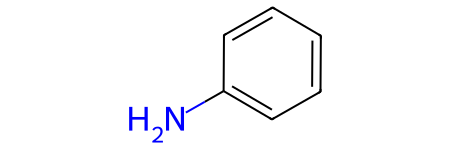

In [109]:
sub_query = "c1ccccc1[NH2]"
Chem.MolFromSmiles(sub_query)

The substructure does a preliminary fingerprint screen to limit the database, then does direct match to remove any false positives. 

In [111]:
sub_search_res = process_search("sub","demo",sub_query)

Filtered 28 false positives; 44 true matches remain.
Runtime for substructure search: 0.04 seconds


Again, we can use mols2grid to display the search results. 

In [112]:
mols2grid.display(sub_search_res,subset=["img","Name"])

MolGridWidget()

We can define a function that will show a set of structures with the substructure match highlighted. 

In [113]:
def display_query_results(smiles_list, smarts, num_per_row=5, start=0, num_to_show=25):
    smiles_list = smiles_list[start:start+num_to_show]
    mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
    query_mol = Chem.MolFromSmarts(smarts)
    match_list = [x.GetSubstructMatch(query_mol) for x in mol_list]
    return Chem.Draw.MolsToGridImage(mol_list,molsPerRow=num_per_row, highlightAtomLists=match_list)

Enable high quality structure rendering. 

In [114]:
uru.rd_make_structures_pretty()

Display the structures

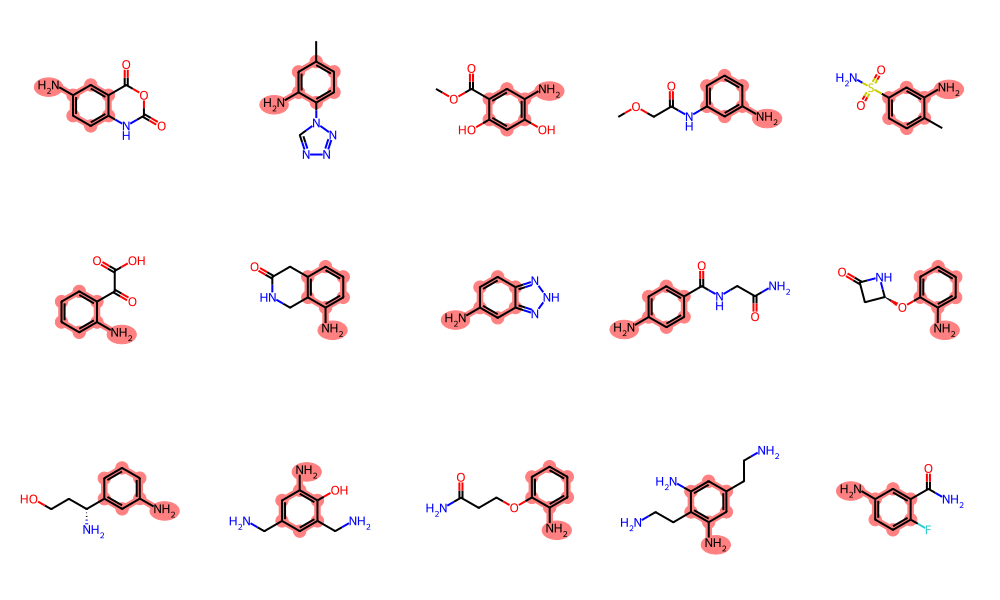

In [115]:
display_query_results(sub_search_res.SMILES,sub_query,num_to_show=15)